# Data Imputation using an Autoencoder


Build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.



1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.




## Colab Link

Include a link to your Colab file here:

Colab Link:
https://colab.research.google.com/drive/11rhC4vsBNZwGhmulqMexOokXQlOCcM0K?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import math

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

----------------------------
For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1. Make sure that you are actually modifying the dataframe df

In [ ]:
#Slice based on specific column names
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]


# Use with Numpy and use with Data Frames

#Min
min_subdf = subdf.min(axis = 0)
print("Data frame method (Minimum Values):")
print(subdf.min(axis = 0))
#Or for min
print("Numpy method (Minimum Values):")
print(np.min(subdf[:], axis =0))

#Max
max_subdf = subdf.max(axis = 0)
print("Data frame method (Maximum Values)")
print(subdf.max(axis = 0))
print("Numpy method (Maximum Values):")
print(np.max(subdf[:], axis = 0))
#Avg Value
print("Data frame method (Maximum Values)")
print(subdf.mean(axis =0))
print("Numpy method (Avg Values):")
print(np.mean(subdf[:], axis = 0))


Data frame method (Minimum Values):
age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64
Numpy method (Minimum Values):
age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64
Data frame method (Maximum Values)
age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64
Numpy method (Maximum Values):
age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64
Data frame method (Maximum Values)
age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64
Numpy method (Avg Values):
age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


In [ ]:
normalized_df = subdf.copy()

for col in normalized_df.columns:
    normalized_df[col] = (normalized_df[col] -min_subdf[col]) / (max_subdf[col] - min_subdf[col])
print("Normalized:")
print(normalized_df)
print("Original:")
print(subdf)


Normalized:
            age     yredu   capgain  caploss    workhr
0      0.301370  0.800000  0.021740      0.0  0.397959
1      0.452055  0.800000  0.000000      0.0  0.122449
2      0.287671  0.533333  0.000000      0.0  0.397959
3      0.493151  0.400000  0.000000      0.0  0.397959
4      0.150685  0.800000  0.000000      0.0  0.397959
...         ...       ...       ...      ...       ...
32556  0.136986  0.733333  0.000000      0.0  0.377551
32557  0.315068  0.533333  0.000000      0.0  0.397959
32558  0.561644  0.533333  0.000000      0.0  0.397959
32559  0.068493  0.533333  0.000000      0.0  0.193878
32560  0.479452  0.533333  0.150242      0.0  0.397959

[32561 rows x 5 columns]
Original:
       age  yredu  capgain  caploss  workhr
0       39     13     2174        0      40
1       50     13        0        0      13
2       38      9        0        0      40
3       53      7        0        0      40
4       28     13        0        0      40
...    ...    ...      ...  

In [ ]:
print("Modify Original df to be Normalized: ")
df[["age", "yredu", "capgain", "caploss", "workhr"]] = normalized_df[["age", "yredu", "capgain", "caploss", "workhr"]]

print(df)


Modify Original df to be Normalized: 
            age               work  fnlwgt          edu     yredu  \
0      0.301370          State-gov   77516    Bachelors  0.800000   
1      0.452055   Self-emp-not-inc   83311    Bachelors  0.800000   
2      0.287671            Private  215646      HS-grad  0.533333   
3      0.493151            Private  234721         11th  0.400000   
4      0.150685            Private  338409    Bachelors  0.800000   
...         ...                ...     ...          ...       ...   
32556  0.136986            Private  257302   Assoc-acdm  0.733333   
32557  0.315068            Private  154374      HS-grad  0.533333   
32558  0.561644            Private  151910      HS-grad  0.533333   
32559  0.068493            Private  201490      HS-grad  0.533333   
32560  0.479452       Self-emp-inc  287927      HS-grad  0.533333   

                  marriage          occupation    relationship    race  \
0            Never-married        Adm-clerical   Not-in-fam

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
total_males_in_dataset = sum(df["sex"] == " Male")
total_females_in_dataset = sum(df["sex"] == " Female")

percent_male = (total_males_in_dataset/(total_females_in_dataset + total_males_in_dataset))*100

print("total males in dataset: ", total_males_in_dataset)
print("Percent Male: " + str(percent_male) + " %")

total males in dataset:  21790
Percent Male: 66.92054912318419 %


In [ ]:
total_females_in_dataset = sum(df["sex"] == " Female")
print("total females in dataset: ", total_females_in_dataset)

#Percntage of people in data set that are female
percent_female = (total_females_in_dataset/(total_females_in_dataset + total_males_in_dataset))*100
print("Percent female: " + str(percent_female) + " %")

total females in dataset:  10771
Percent female: 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
print("Missing: ")
print(missing)
print("Missing[27] = ", missing[27]) # Should give true since it is missing at the 27th entry

# note: the ones with True have this df[c] == " ?" for c in catcols statement valid
print("Data Frame With Missing:")
print(df_with_missing)
print("Data Frame Without Missing:")
df_not_missing = df[~missing]
print(df_not_missing)
#####################################################
# To count How many records contained missing features:
# take the missing and find how many of these were true
print("How many Missing Values were True: ")
print(missing[:].value_counts()[1])
missing_records = missing[:].value_counts()[1]
# [1] takes only true values
#Note: missing[:].value_counts() gave
#  False  [number_of false's in col]
# True    [number of trues in col]
# Answer is continued the code below:

Missing: 
0        False
1        False
2        False
3        False
4        False
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Length: 32561, dtype: bool
Missing[27] =  True
Data Frame With Missing:
            age     yredu   capgain  caploss    workhr work  \
27     0.506849  0.600000  0.000000      0.0  0.602041    ?   
61     0.205479  0.200000  0.000000      0.0  0.397959    ?   
69     0.109589  0.600000  0.000000      0.0  0.397959    ?   
77     0.684932  0.333333  0.000000      0.0  0.010204    ?   
106    0.000000  0.333333  0.340953      0.0  0.316327    ?   
...         ...       ...       ...      ...       ...  ...   
32530  0.246575  0.800000  0.000000      0.0  0.551020    ?   
32531  0.178082  0.800000  0.000000      0.0  1.000000    ?   
32539  0.739726  1.000000  0.000000      0.0  0.091837    ?   
32541  0.328767  0.533333  0.000000      0.0  0.316327    ?   
32542  0.753425  0.533333  0.000000      0.0  0.244898    ? 

In [ ]:
# Percentage of records removed:
# In the missing variable, find the total number of records there were
total_records = len(missing)
percent_records_removed = (missing_records/total_records) *100
print("Total Records: ",total_records )
print("\n\nSolution:")
print("Number of Records with Missing Features:", missing_records)
print("Percentage Records removed: ", percent_records_removed, "%")

Total Records:  32561


Solution:
Number of Records with Missing Features: 1843
Percentage Records removed:  5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
types_of_work = set(df_not_missing["work"])
#print("All work values in df_not_missing:")
#print(df_not_missing["work"])

print("All possible values of the feature Work")
print(types_of_work)

All possible values of the feature Work
{' Private', ' State-gov', ' Local-gov', ' Federal-gov', ' Self-emp-not-inc', ' Self-emp-inc', ' Without-pay'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
df_not_missing[:3]

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
0,0.301370,0.800000,0.02174,0.0,0.397959,State-gov,Never-married,Adm-clerical,Bachelors,Not-in-family,Male
1,0.452055,0.800000,0.00000,0.0,0.122449,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Bachelors,Husband,Male
2,0.287671,0.533333,0.00000,0.0,0.397959,Private,Divorced,Handlers-cleaners,HS-grad,Not-in-family,Male


In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]


,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
total_cols_in_data = len(data.columns)
print("Total columns in data: ",total_cols_in_data )

Total columns in data:  57


This Number comes from the data frame called data.. data was made using df_not_missing where it was converted using get_dummies that makes additional features (for columns that have words in them) and their outputs a boolean value. It doesn't affect features with numbers. This is why the features are a high number. For example, work has state-gov,private etc.. as values in the column (instead of values now, they will be converted as separate features and each of those features will have True/False underneath them.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)
print(datanp)

[[0.30136988 0.8        0.02174022 ... 0.         0.         1.        ]
 [0.4520548  0.8        0.         ... 0.         0.         1.        ]
 [0.28767124 0.53333336 0.         ... 0.         0.         1.        ]
 ...
 [0.56164384 0.53333336 0.         ... 0.         1.         0.        ]
 [0.06849315 0.53333336 0.         ... 0.         0.         1.        ]
 [0.47945204 0.53333336 0.15024151 ... 1.         1.         0.        ]]


In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        #print(feature)
        #print(value)
        #print(i)
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i # start index only
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)
print("All Cat Index", cat_index)
print("All Cat values", cat_values)
def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]
print("get_onehot 1st row for work: ",get_onehot(datanp[1],"work")) # self_emp_not inc should be the one that is true in it, and have 1 in the 5th index
def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature # This for a specific record or row
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    #all_feature_types =cat_values[feature]
    #Find the index where the maximum number in the oneHot array occurs.
    indexOfMaxValue = np.argmax(onehot)
    specific_category = cat_values[feature][indexOfMaxValue]
    return specific_category

All Cat Index {'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
All Cat values {'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}
get_onehot 1st row for work:  [0. 0. 0. 0. 1. 0. 0.]


In [ ]:
#Rough work
np.argmax(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]))
# This gives at index 2, the maximum value is found  which is 1.1

2

In [ ]:
# Rough work
cat_values["work"][2]

'Private'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [ ]:
print(get_feature(datanp[1], "work"))
# The above matches what is in the 1st row starting at index 0
print(get_features(datanp[1]))

Self-emp-not-inc
{'work': 'Self-emp-not-inc', 'marriage': 'Married-civ-spouse', 'occupation': 'Exec-managerial', 'edu': 'Bachelors', 'relationship': 'Husband', 'sex': 'Male'}


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
# Number of Rows
print("total records: ", data.shape[0])
total_records = data.shape[0]
#Ending Rows Maximum
train_percent = 0.7
val_percent = 0.15 + 0.7  # gives leftover 15%
test_percent = 1 #last amount left
#print(train_percent*total_records)
max_train_row = math.floor(train_percent*total_records)
#print(val_percent*total_records)
max_val_row = math.floor(val_percent*total_records)
max_test_row = total_records
#print(test_percent*total_records)
# not including the last row eg [inc: not_including]
train_data_records = datanp[0:max_train_row]
val_data_records = datanp[max_train_row:max_val_row]
test_data_records = datanp[max_val_row: total_records]
print("Train Data Shape:", train_data_records.shape)
print("Val Data Shape:", val_data_records.shape)
print("Test Data Shape:", test_data_records.shape)
print("Number of Rows or Records in Train: ",train_data_records.shape[0], "Percent: ",train_data_records.shape[0]/total_records, " %" )
print("Number of Rows or Records in Val: ", val_data_records.shape[0], "Percent: ", val_data_records.shape[0]/total_records, " %")
print("Number of Rows or Records in Test: ",test_data_records.shape[0], "Percent: ", test_data_records.shape[0]/total_records, " %")


total records:  30718
Train Data Shape: (21502, 57)
Val Data Shape: (4608, 57)
Test Data Shape: (4608, 57)
Number of Rows or Records in Train:  21502 Percent:  0.6999804674783514  %
Number of Rows or Records in Val:  4608 Percent:  0.15000976626082427  %
Number of Rows or Records in Test:  4608 Percent:  0.15000976626082427  %


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 39),
            nn.ReLU(),
            nn.Linear(39, 11)

        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 39),
            nn.ReLU(),
            nn.Linear(39, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

There is a sigmoid activation in the last step of the decoder to ensure the output is between 0 to 1. The autoencoder must be able to predict the missing data in the table (which is currenty made of 0 and 1). One function that can achieve this is: a sigmoid function which outputs a value between 0 and 1 (as seen from its graph). This output will then be used to fill in the missing value in the data dataFrame.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def calculate_val_loss(model, val_loader, criterion):
  val_loss = 0.0 # total val loss
  for index, data in enumerate(val_loader, 0):
                 #labels multiple
    input_values = zero_out_random_feature(data.clone())
    resutants = model(input_values)
    #Labels already normalized here since 0 or 1 conversion to values? or does one need to normalize them, why does one need to normalize?
                    #labels
    #norm_labels = (label -  torch.min(label))/(torch.max(label) - torch.min(label))
    loss = criterion(resutants, data)
    val_loss += loss.item()

  avg_val_loss = val_loss / (index + 1)

  return avg_val_loss

def get_model_name(name, learning_rate, epoch):

    path = "model_{0}_lr{1}_epoch{2}".format(name,learning_rate,epoch)
    return path
import time
import matplotlib.pyplot as plt
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    n = 0
    train_accuracy = []
    val_accuracy = []
    iteration_count = []
    val_loss_per_data = []
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    epoch_x_axis = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        i = 0
        train_loss_per_data = 0.0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #Number of iterations
            iteration_count.append(n)
            train_loss_per_data += loss.item()
            n += 1
            i += 1
        train_accuracy.append(get_accuracy(model, train_loader))
        val_accuracy.append(get_accuracy(model, valid_loader))
        val_loss[epoch] = calculate_val_loss(model, valid_loader,criterion)
        train_loss[epoch] = float(train_loss_per_data) / (i)
        model_path = get_model_name(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        print(("Epoch {}: |Train loss: {} |"+
               "Validation loss : {} |, Train Accuracy: {}, |Validation Accuracy: {}").format(
                   epoch + 1,
                   train_loss[epoch],
                   val_loss[epoch],
                   train_accuracy[epoch],
                   val_accuracy[epoch]
                   ))
        epoch_x_axis[epoch] = epoch + 1

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    #print( "\nTrain Loss : ", train_loss, "\nVal loss: ", val_loss, "\nTrain Accuracy: ", train_accuracy, "\nVal Accuracy: ", val_accuracy)
    plot_train_val_acc_loss(epoch_x_axis,train_loss, val_loss, train_accuracy, val_accuracy)



### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [ ]:
## Plot the the curves

def plot_train_val_acc_loss(epoch_x_axis,train_loss, val_loss, train_accuracy, val_accuracy):
   # plotting
    plt.title("Training and Validation Loss")
    plt.plot(epoch_x_axis, train_loss, label="Train")
    plt.plot(epoch_x_axis, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    # Plot train and val accuracy for each iteration
    plt.title("Training and Validation Accuracy")
    plt.plot(epoch_x_axis, train_accuracy, label="Train")
    plt.plot(epoch_x_axis, val_accuracy, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_accuracy[-1]))
    print("Final Validation Accuracy: {}".format(val_accuracy[-1]))
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

_______________________
Hyperparameters used:

*   Learning Rate = 1e-4 (default)
*   Batch Size = 32
*   Num_epochs = 30
*  original number of layers in the autoencoder/ decoder









Epoch 1: |Train loss: 0.13770043436393498 |Validation loss : 0.1825449300701158 |, Train Accuracy: 0.4369205965336558, |Validation Accuracy: 0.43601707175925924
Epoch 2: |Train loss: 0.07040521728673152 |Validation loss : 0.17474902623839544 |, Train Accuracy: 0.46079434471211983, |Validation Accuracy: 0.4597800925925926
Epoch 3: |Train loss: 0.06492392582974087 |Validation loss : 0.15011269599199295 |, Train Accuracy: 0.5141227172666109, |Validation Accuracy: 0.5143952546296297
Epoch 4: |Train loss: 0.05665005701372311 |Validation loss : 0.13983235449383133 |, Train Accuracy: 0.5329814280842092, |Validation Accuracy: 0.5323350694444444
Epoch 5: |Train loss: 0.05409060842135832 |Validation loss : 0.13352735824229425 |, Train Accuracy: 0.5516076023935758, |Validation Accuracy: 0.5489004629629629
Epoch 6: |Train loss: 0.05058224089000197 |Validation loss : 0.12226465252930657 |, Train Accuracy: 0.5629321303444641, |Validation Accuracy: 0.5607277199074074
Epoch 7: |Train loss: 0.046036146

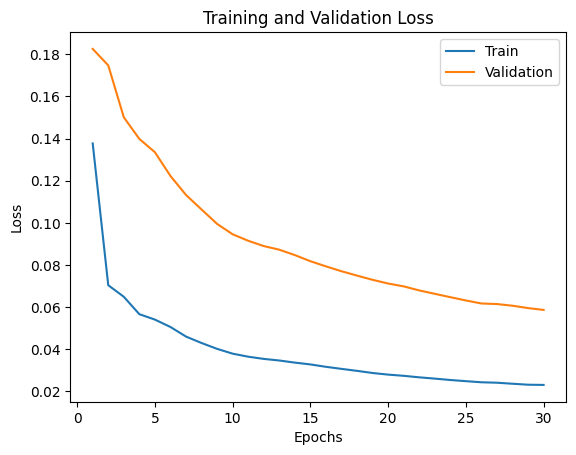

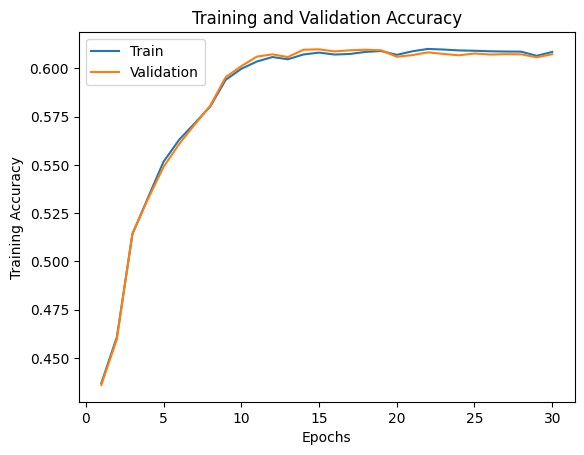

Final Training Accuracy: 0.6084937835240133
Final Validation Accuracy: 0.6072771990740741
Final Training Loss: 0.023085676025532718
Final Validation Loss: 0.058670395331686005


In [ ]:
#num_workers=1
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 32,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 32,shuffle=True,num_workers=1)
model_autoencoder = AutoEncoder()

train(model_autoencoder, train_loader, val_loader, num_epochs=30)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

_________________
Attempt Model # 1:
The model in part c  Validation and training accuracy reached a plateau but are closely follwing each other. This means that the model is not overfitted yet but it is not improving.
Number of epochs are increased to see if the plateau is overcome. (learning rate will be changd in attempt # 2 if the model still can't overcome the plateau for train or val accuracy)

Hyperparameters used:

*   Learning Rate = 1e-4 (default)
*   Batch Size = 32
*   Num_epochs = 200
*  original number of layers in the autoencoder/ decoder


Effect after running the code:


The model_autoencoder_v1 took very long to train. The train and val accuracy curves are following each other and are not overfitted yet. More epochs are needed at this rate but with more train time. The train_and val accuracy appear to increase.

This may be because the learning_rate was very small, thus taking smaller steps to reach the optimal values and more time.

Results:



* Final Training Accuracy: 0.6582023377670294
* Final Validation Accuracy: 0.6553096064814815
* Final Training Loss: 0.012412942051014397
* Final Validation Loss: 0.03112315210072618


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 32,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 32,shuffle=True,num_workers=1)
model_autoencoder_v1 = AutoEncoder()

train(model_autoencoder_v1, train_loader, val_loader, num_epochs=200)

Attempt Model # 2:

To speed up training and allow for slightly larger steps to be taken (and a learning rate of 0.1 was attempted but was instantly overfitted within 5 epochs as the curve was a horizontal line). So, the learning_rate that is chosen as 0.001.
The number of epochs are also lowered due to increasing the learning_rate.

Hyperparameters used:

*   Learning Rate = 0.001
*   Batch Size = 32
*   Num_epochs = 121
*  original number of layers in the autoencoder/ decoder


Effect after running the code:
Accuracy Improved.
Increasing the learning rate and decreasing the epochs took a little less time to train.
Increasing the learning rate allowed the graph to take larger steps to reach the global optimum during gradient descent

Accuray is better than attempt 1.  
* Final Training Accuracy: 0.7138638266207794
* Final Validation Accuracy: 0.7084056712962963
* Final Training Loss: 0.008634919831820298
* Final Validation Loss: 0.022882014611049703



In [ ]:
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 32,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 32,shuffle=True,num_workers=1)
model_autoencoder_v2 = AutoEncoder()

train(model_autoencoder_v2, train_loader, val_loader, learning_rate=0.001, num_epochs=121)

Attempt Model # 3:

Increase the batch_size to 64.

Hyperparameters used:

*   Learning Rate = 0.001
*   Batch Size = 64
*   Num_epochs = 121
*  original number of layers in the autoencoder/ decoder


Effect after running the code:
* Final Training Accuracy: 0.6385995101230894
* Final Validation Accuracy: 0.6307870370370371
* Final Training Loss: 0.016105589237884573
* Final Validation Loss: 0.021426212957553696

Increasing the batch_size decreased the validation and train accuracy.
The model is still underfitted



In [ ]:
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 64,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 64,shuffle=True,num_workers=1)
model_autoencoder_v3 = AutoEncoder()

train(model_autoencoder_v3, train_loader, val_loader, num_epochs=121)

Attempt Model # 4:
Increase the learning rate to 0.01, decrease the batch_size to 16 since attempt 3 did not work as intended.

Hyperparameters used:

*   Learning Rate = 0.01
*   Batch Size = 16
*   Num_epochs = 121
*  original number of layers in the autoencoder/ decoder


Effect after running the code:
It had a worse effect. Learning rate was faster and the batch size even smaller.

At epoch 94: |Train loss: 0.029306911649265594 |Validation loss : 0.14608078314350886 |, Train Accuracy: 0.5127430006511022, |Validation Accuracy: 0.5149016203703703 which was worse than all the previous models.






In [ ]:
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 16,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 16,shuffle=True,num_workers=1)
model_autoencoder_v4 = AutoEncoder()

train(model_autoencoder_v4, train_loader, val_loader, learning_rate = 0.01, num_epochs=121)

Attempt Model # 5:
Keep the learning rate at 0.002, decrease the batch_size to 16.


*   Learning Rate = 0.002
*   Batch Size = 16
*   Num_epochs = 121
*  original number of layers in the autoencoder/ decoder


Effect after running the code:

The Validation accuracy and training accuracy were both about 67%. This meant that more epochs were required further and for several epochs the graph stayed at 67%. There wasn't much improvement in this new model in attempt to increase the accuracy.






In [ ]:
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 16,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 16,shuffle=True,num_workers=1)
model_autoencoder_v5 = AutoEncoder()

train(model_autoencoder_v5, train_loader, val_loader, learning_rate = 0.002, num_epochs=121)

Attempt Model # 6:
Keep the learning rate at 0.001 (from the model 2), increase the batch_size to 512 (so that the training is faster), increase_number of epochs


*   Learning Rate = 0.001
*   Batch Size = 512
*   Num_epochs = 500
*  original number of layers in the autoencoder/ decoder


Effect after running the code:
Accuracy plateaued after certain epochs
Final Training Accuracy: 0.6562412798809413
Final Validation Accuracy: 0.6527416087962963
Final Training Loss: 0.011520877136804518
Final Validation Loss: 0.0021060133565282612





In [ ]:
train_loader = torch.utils.data.DataLoader(train_data_records,batch_size = 512,shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data_records,batch_size = 512,shuffle=True,num_workers=1)
model_autoencoder_v5 = AutoEncoder()

train(model_autoencoder_v5, train_loader, val_loader, learning_rate = 0.001, num_epochs=500)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data_records,batch_size = 32,shuffle=True, num_workers=1)
# the model that is used is the model that performed the best with its corresponding batch_size for the test_loader
#model attempt 2 was chosen
print("The test accuracy for the model chosen is: ", get_accuracy(model_autoencoder_v2, test_loader)*100, " %")

The test accuracy for the model chosen is:  71.36140046296296  %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
'''
Thought process:

test_accuracy ==>need test data frame in terms of words (and not 0s and 1s ) OR get 0s and 1s for each category and convert to words (not efficient please see green comments)
max_val_row = math.floor(val_percent*total_records)
test_data_records = datanp[max_val_row: total_records]
where
datanp = data.values.astype(np.float32)
data = pd.get_dummies(df_not_missing) # has column names on the top

All Cat Index {'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
All Cat values {'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take
'''
# go row wise and store the most common feature for each column/feature -->inefficient way
# can use pre-built functions for pandas
# thus, use df_not_missing instead

# feature = column
most_common_value = {} # create a dictionary so that indicies can be strings or features
for feature in df_not_missing:
  #find how mnay times each value within the feature happens
  #print(feature)
  #print(df_not_missing[feature].value_counts())
  all_values_in_each_feature_occurance = df_not_missing[feature].value_counts()

  # value_counts gives what are the output values and the how many times each output occurs
  # for yredu 0.533333 occurs 9968
  # .max returns the maximum frequency eg 9968
  #print(df_not_missing[feature].value_counts().max())
  # to get index , can use idxmax
  most_common_value[feature] = all_values_in_each_feature_occurance.idxmax()


print(most_common_value)

{'age': 0.2602739726027397, 'yredu': 0.5333333333333333, 'capgain': 0.0, 'caploss': 0.0, 'workhr': 0.3979591836734694, 'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}


In [ ]:
accuracy_per_feature = []
count = 0
for feature in df_not_missing:

  missing_feature_equals_common_pred = (most_common_value[feature] == df_not_missing[feature])
  total_number_match = df_not_missing[missing_feature_equals_common_pred].count()
  total_rows_records = df_not_missing.shape[0]
  accuracy_per_feature.append(total_number_match/total_rows_records)

# in the dictionary, sum of all the values
#note that accuracy_per_feature has index 0 to len(features) where index i can be found using cat index
total_accuracy = sum(accuracy_per_feature)/len(accuracy_per_feature)

print("The Accuracy of the Baseline model is ", total_accuracy[0]*100, " %")
# the reason why total_accuracy[0] is because total_accuracy gave an array with the same number


The Accuracy of the Baseline model is  49.538322215579846  %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

_________________
The test accuracy for the baseline model is 49.5% and using the autoencoder the accuracy is 71.4% . The autoencoder model performs better than the baseline model.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
print("Test reocrds",  test_data_records[0])
# the first row
print()
print("Test reocrds get features",  get_features(test_data_records[0]))


Test reocrds [0.369863  0.8       0.        0.        0.4489796 0.        0.
 1.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 1.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 1.        0.        0.        0.        0.        0.        0.
 0.        1.        0.        0.        0.        0.        1.
 0.       ]

Test reocrds get features {'work': 'Private', 'marriage': 'Never-married', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Female'}


______________

Given the occupation or work, the education level may be guessed.
However, the guess may not be accurate representation without more information; and the accuracy of guesses made by humans would be very low due to assumptions and bias.
Thus, I believe it is not reasonable for a human to be able to predict the person's eduction level based on these features.


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
#First remove the edu feature from the the dataset before passing to model to see if model can predict,
# zero_out_features returns records
modified_test_records = zero_out_feature(test_data_records[0:1], "edu")

# pass in tensor to model
modified_test_torch = torch.tensor(modified_test_records[0])

output_model_prediction = model_autoencoder_v2(modified_test_torch)
print("Output model Predict:", output_model_prediction)
print("Type: ", type(output_model_prediction))
numpy_output_model_prediction = output_model_prediction.detach().numpy()

# detach.numpy is needed because the computational graph of tensor must be removed via detach. the computational graph comes with tensor

print("Numpy Format OutPutModel Predict:", numpy_output_model_prediction)
print("\n\nResults: \n")
# get_feature takes input record or a numpy array and feature
print("The feature that was missing should be: ", get_feature(numpy_output_model_prediction, "edu"))


Output model Predict: tensor([2.6436e-01, 7.9101e-01, 5.6694e-16, 5.0091e-03, 4.2820e-01, 2.4531e-12,
        1.8831e-16, 9.8758e-01, 7.5880e-09, 1.3954e-04, 5.3931e-05, 8.4797e-27,
        2.5467e-03, 5.0160e-27, 4.6311e-11, 5.3539e-12, 9.9864e-01, 4.3867e-12,
        1.2728e-09, 1.5230e-02, 3.0180e-19, 5.7394e-05, 4.4152e-04, 5.2291e-04,
        4.2463e-06, 5.4011e-04, 3.2552e-06, 4.9674e-03, 9.6886e-01, 1.5193e-05,
        1.1541e-03, 9.3054e-04, 3.6058e-11, 5.1445e-17, 6.3492e-07, 2.8801e-11,
        5.8935e-14, 2.0940e-26, 3.8006e-25, 0.0000e+00, 4.6512e-06, 1.8348e-02,
        6.7042e-01, 3.4754e-08, 0.0000e+00, 4.3646e-01, 1.3426e-09, 2.0035e-02,
        4.4928e-12, 2.0537e-26, 9.9767e-01, 1.1539e-04, 4.2566e-04, 2.1134e-03,
        1.3951e-32, 9.8703e-01, 1.4394e-02], grad_fn=<SigmoidBackward0>)
Type:  <class 'torch.Tensor'>
Numpy Format OutPutModel Predict: [2.6436004e-01 7.9100627e-01 5.6694255e-16 5.0091292e-03 4.2819995e-01
 2.4530608e-12 1.8830990e-16 9.8758137e-01 7.58800

_______________________
The Autoencoder correctly predicts the education level

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
#Since basline model is most_common_value, it is a dictionary and can be accessed by inputting the keys to get its values
print("Baseline Model prediction: ", most_common_value["edu"])

Baseline Model prediction:   HS-grad


___________
The baseline model is unable to predict the education level effectively because of the data it is provided. The data contains frequently High School graduates; thus, the baseline is more likely to classify the education level as HS graduate.
The baseline model is highly dependent on the dataset values collected.